#### Following [wmt analysis: full3D_tutorial.ipynb](https://github.com/hdrake/xwmt/blob/main/examples/full3D_tutorial.ipynb) and [Baltic example](https://github.com/hdrake/xwmb/blob/main/examples/Baltic_example.ipynb)


In [4]:
import xarray as xr
import numpy as np

In [5]:
import xwmb
import xwmt
import xgcm

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
xwmb.__version__, xwmt.__version__, xgcm.__version__

('0.0.1', '0.0.3', '0.8.2.dev15+g7492277')

In [8]:
hfdrake_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/"
ds = xr.open_mfdataset(f"{hfdrake_path}/data/WMT_monthly/ocean_month_rho2.0186*", chunks={"xh":360, "yh":270, "time":1}) #chunks={'time':1})
snap = xr.open_mfdataset(f"{hfdrake_path}/data/WMT_monthly/ocean_month_rho2_snap.0186*", chunks={"xh":360, "yh":270, "time":1}) #chunks={'time':1})
static = xr.open_mfdataset(f"{hfdrake_path}/data/WMT_monthly/ocean_month_rho2.static.nc", chunks={"xh":360, "yh":270}) #chunks={'time':1})

In [9]:
# Merge snapshots with time-averages
snap = snap.rename({
    **{'time':'time_bounds'},
    **{v:f"{v}_bounds" for v in snap.data_vars}
})
ds = xr.merge([ds.sel(time=ds.time[1:]), snap])

In [10]:
# Add core coordinates of static to ds
ds = ds.assign_coords({
    "areacello": xr.DataArray(static["areacello"].values, dims=('yh', 'xh',)), # Required for area-integration
    "lon": xr.DataArray(static["geolon"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "lat": xr.DataArray(static["geolat"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "xq": xr.DataArray(static["xq"].values, dims=('xq',)),
    "yq": xr.DataArray(static["yq"].values, dims=('yq',)),
    "deptho": xr.DataArray(static["deptho"].values, dims=('yh', 'xh',)),
    "geolon": xr.DataArray(static["geolon"].values, dims=('yh', 'xh',)),
    "geolat": xr.DataArray(static["geolat"].values, dims=('yh', 'xh',)),
    "geolon_c": xr.DataArray(static["geolon_c"].values, dims=('yq', 'xq',)),
    "geolat_c": xr.DataArray(static["geolat_c"].values, dims=('yq', 'xq',)),
})

# xgcm grid for dataset
coords = {
    'X': {'center': 'xh', 'right': 'xq'},
    'Y': {'center': 'yh', 'right': 'yq'},
    'Z': {'center': 'rho2_l', 'outer': 'rho2_i'}
}
metrics = {
    ('X','Y'): "areacello", # Required for area-integration
}

ds['tos'] = ds['thetao'].isel(rho2_l=0)
ds['sos'] = ds['so'].isel(rho2_l=0)

grid = xgcm.Grid(ds.copy(), coords=coords, metrics=metrics, boundary={'X':'extend', 'Y':'extend', 'Z':'extend'}, autoparse_metadata=False)

In [11]:
wm = xwmt.WaterMass(grid)

In [12]:
ds

<xarray.Dataset>
Dimensions:                         (time: 59, rho2_l: 74, yh: 1080, xh: 1440,
                                     nv: 2, rho2_i: 75, yq: 1080,
                                     time_bounds: 60, xq: 1440)
Coordinates: (12/17)
  * nv                              (nv) float64 1.0 2.0
  * rho2_i                          (rho2_i) float64 997.0 ... 1.039e+03
  * rho2_l                          (rho2_l) float64 1.004e+03 ... 1.038e+03
  * time                            (time) object 0186-02-15 00:00:00 ... 019...
  * xh                              (xh) float64 -299.7 -299.5 ... 59.78 60.03
  * yh                              (yh) float64 -80.39 -80.31 ... 89.84 89.95
    ...                              ...
  * yq                              (yq) float64 -80.35 -80.27 ... 89.89 90.0
    deptho                          (yh, xh) float32 nan nan nan ... nan nan nan
    geolon                          (yh, xh) float32 -299.7 -299.5 ... 60.0 60.0
    geolat                          (yh, xh) float32 -79.81 -79.81 ... 64.11
    geolon_c                        (yq, xq) float32 -299.6 -299.4 ... -300.0
    geolat_c                        (yq, xq) float32 -79.77 -79.77 ... 64.06
Data variables: (12/36)
    S_advection_xy                  (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    average_DT                      (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1                      (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2                      (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds                       (time, nv) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    Sh_tendency_vert_remap          (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    ...                              ...
    so_bounds                       (time_bounds, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    thetao_bounds                   (time_bounds, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    thkcello_bounds                 (time_bounds, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    volcello_bounds                 (time_bounds, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    tos                             (time, yh, xh) float32 dask.array<chunksize=(1, 270, 360), meta=np.ndarray>
    sos                             (time, yh, xh) float32 dask.array<chunksize=(1, 270, 360), meta=np.ndarray>
Attributes:
    filename:            ocean_month_rho2.018601-019012.S_advection_xy.nc
    title:               CM4_piControl_C_restartyear148
    associated_files:    areacello: 01860101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  volcello areacello

In [13]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
xbudget.collect_budgets(grid._ds, budgets_dict)

(10.0, 38.0)

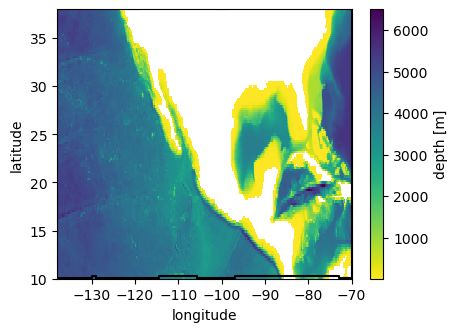

In [14]:
import numpy as np
import regionate
import matplotlib.pyplot as plt

# Note: the properties of this region are quite different from the rest of the Baltic!
name = "MANSO"
#lons = np.array([8.,   20.,  29., 24.5, 24.5, 26.1, 17.5, 11.5])
#lons = np.arange([-138, 0, 3.4])
lons = np.array([-138.,-120.,-100., -70., -70., -100., -120., -138.])
#lats = np.arange(8, 49, 1)
lats = np.array([10., 10., 10., 10., 38., 38., 38., 38.])
#lats = np.array([53.5, 53.5, 54.5,  59.,  61.,  63., 64.5,  62.])
manso_region = regionate.GriddedRegion(name, lons, lats, grid)

plt.figure(figsize=(4.75,3.5))
pc = plt.pcolor(
    grid._ds['geolon_c'],
    grid._ds['geolat_c'],
    grid._ds['deptho'],
    cmap="viridis_r"
)
plt.colorbar(pc, label="depth [m]")
plt.plot(regionate.loop(manso_region.lons), regionate.loop(manso_region.lats), color="k");
plt.xlabel("longitude");
plt.ylabel("latitude");
plt.xlim(np.min(lons), np.max(lons))
plt.ylim(np.min(lats), np.max(lats))

#plt.xlim(-200,5)
#plt.ylim(-10,80)

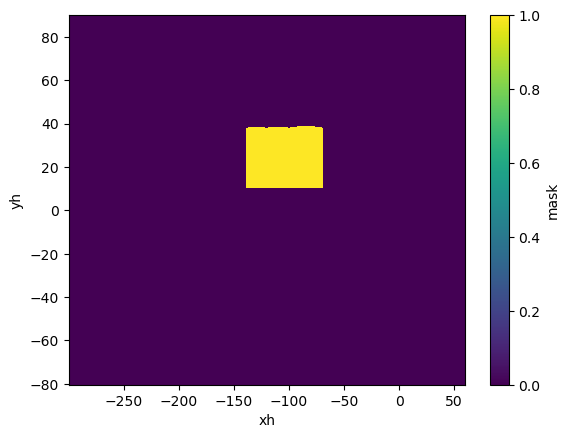

In [15]:
manso_region.mask.plot()

In [16]:
import warnings

lam = "heat"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict,
        manso_region.mask,
        assert_zero_transport=True
    )
    wmb.mass_budget(lam, greater_than=True, default_bins=True)
    #wmb.wmt.load()
    wmt = wmb.wmt

In [158]:
wmb_bounds_greater_than = wmb.grid._ds['mass_bounds_greater_than'].load()

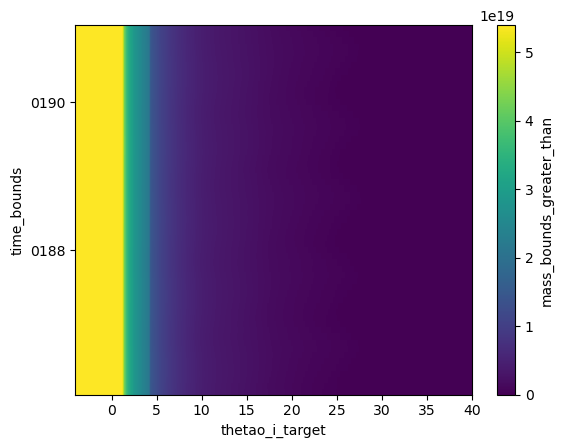

In [159]:
wmb_bounds_greater_than.plot()

In [191]:
wmb_bounds_greater_than.mean('time_bounds')
print(wmb_bounds_greater_than.isel(time_bounds=7).time_bounds.values)
print(wmb_bounds_greater_than.isel(time_bounds=19).time_bounds.values)
print(wmb_bounds_greater_than.isel(time_bounds=31).time_bounds.values)
print(wmb_bounds_greater_than.isel(time_bounds=43).time_bounds.values)

0186-09-01 00:00:00
0187-09-01 00:00:00
0188-09-01 00:00:00
0189-09-01 00:00:00


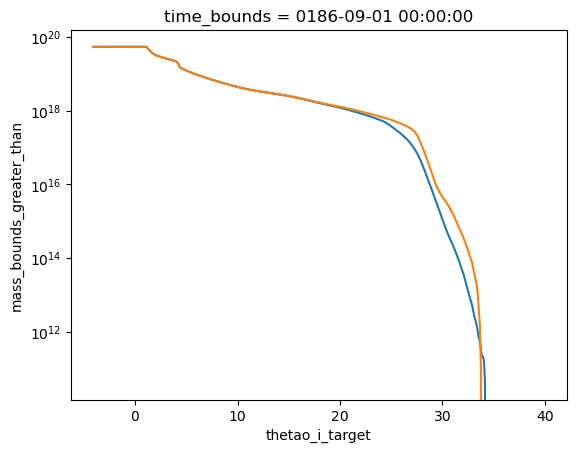

In [192]:
wmb_bounds_greater_than.mean('time_bounds').plot()
wmb_bounds_greater_than.isel(time_bounds=7).plot()
#wmb_bounds_greater_than.isel(time_bounds=19).plot()
#wmb_bounds_greater_than.isel(time_bounds=31).plot()
#wmb_bounds_greater_than.isel(time_bounds=43).plot()
plt.yscale('log')

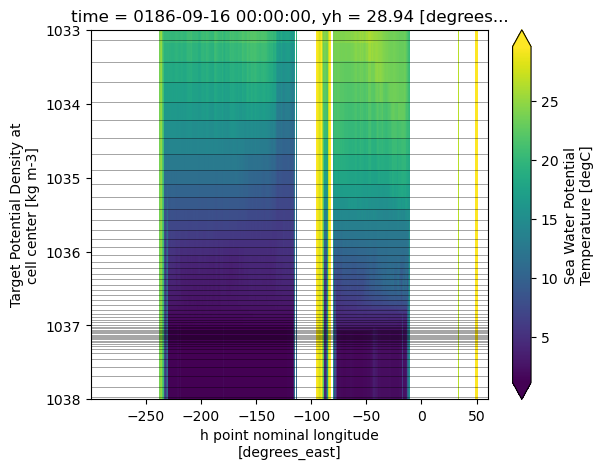

In [193]:
ds.thetao.isel(time=7).sel(yh=29, method="nearest").plot(robust = True)
plt.ylim(1038, 1033)
for rho2 in ds.rho2_i:
    plt.axhline(rho2, color = 'k', lw = '0.5', alpha = 0.5)

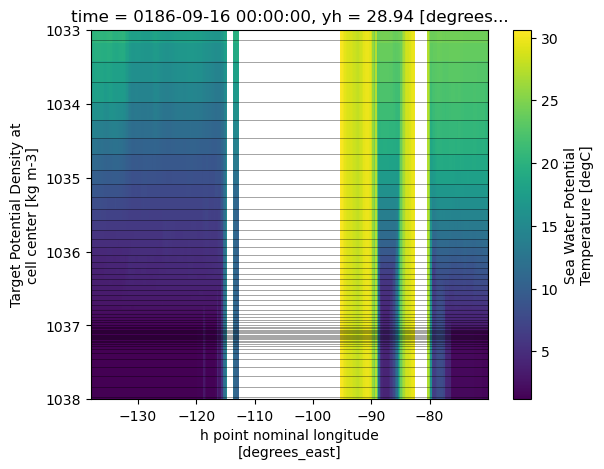

In [203]:
ds.thetao.isel(time=7).sel(yh=29, method="nearest").sel(xh=slice(-138,-70)).plot()
plt.ylim(1038, 1033)
for rho2 in ds.rho2_i:
    plt.axhline(rho2, color = 'k', lw = '0.5', alpha = 0.5)

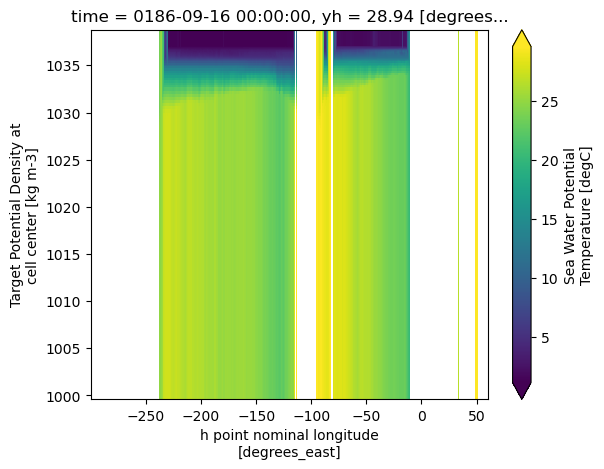

In [198]:
ds.thetao.isel(time=7).sel(yh=29, method="nearest").plot(robust = True)

In [171]:
ds.thetao

<xarray.DataArray 'thetao' (time: 59, rho2_l: 74, yh: 1080, xh: 1440)>
dask.array<getitem, shape=(59, 74, 1080, 1440), dtype=float32, chunksize=(1, 74, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * rho2_l     (rho2_l) float64 1.004e+03 1.014e+03 ... 1.038e+03 1.038e+03
  * time       (time) object 0186-02-15 00:00:00 ... 0190-12-16 12:00:00
  * xh         (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh         (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
    areacello  (yh, xh) float32 3.439e+07 3.437e+07 ... 2.097e+06 9.053e+05
    lon        (yh, xh) float32 -299.7 -299.5 -299.2 -299.0 ... 60.0 60.0 60.0
    lat        (yh, xh) float32 -79.81 -79.81 -79.8 -79.8 ... 64.33 64.22 64.11
    deptho     (yh, xh) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    geolon     (yh, xh) float32 -299.7 -299.5 -299.2 -299.0 ... 60.0 60.0 60.0
    geolat     (yh, xh) float32 -79.81 -79.81 -79.8 -79.8 ... 64.33 64.22 64.11
Attributes:
    long_name:      Sea Water Potential Temperature
    units:          degC
    cell_methods:   area:mean rho2_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

In [ ]:
ds.thetao.deptho.plot()

In [45]:
print(wm.grid._ds['thetao'].isel(time=0).time.values)
print(wm.grid._ds['thetao'].isel(rho2_l=20).rho2_l.values)
print(wm.grid._ds['thetao'].sel(yh=29,method='nearest').yh.values)

0186-02-15 00:00:00
1033.0665
28.935306661851726


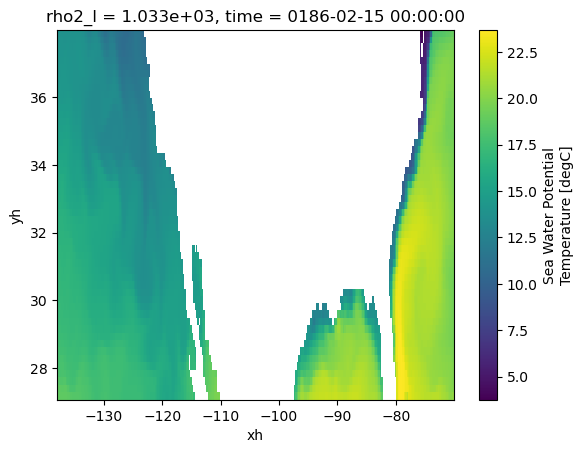

In [74]:
wm.grid._ds['thetao'].isel(time=0).isel(rho2_l=20).sel(yh=slice(27,38)).sel(xh=slice(-138,-70)).plot()
#plt.title(f"{wm.grid._ds.thetao.isel(time=0).time.values},{wm.grid._ds.thetao.sel(yh=slice(27,38),method='nearest').yh.values},{wm.grid._ds.thetao.isel(rho2_l=20).rho2_l.values}")

In [108]:
wm.get_density()

In [139]:
temp = wm.grid._ds['thetao'].isel(time=0).sel(yh=29, method="nearest").sel(xh=slice(-138,-70)).compute()
z_section = wm.grid._ds['z'].isel(time=0).sel(yh=29, method="nearest").sel(xh=slice(-138,-70)).compute()

Text(0.5, 1.0, 'date=0186-02-15 00:00:00, yh=28.935306661851726')

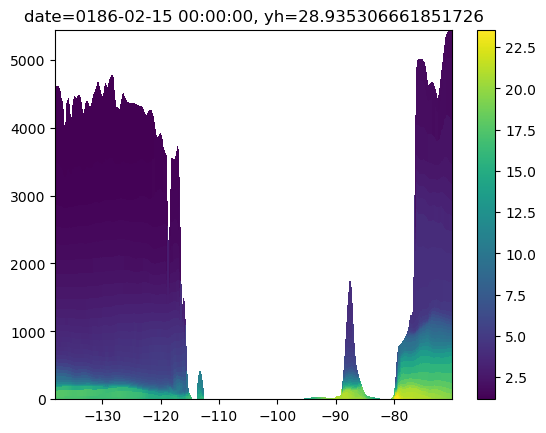

In [140]:
import matplotlib.pyplot as plt

plt.pcolor(
    z_section.xh*xr.ones_like(z_section.rho2_l),
    z_section,
    temp.transpose()
)
plt.colorbar()
plt.title(f'date={z_section.time.values}, yh={z_section.yh.values}')


In [141]:
temp = wm.grid._ds['thetao'].isel(time=7).sel(yh=29, method="nearest").sel(xh=slice(-138,-70)).compute()
z_section = wm.grid._ds['z'].isel(time=7).sel(yh=29, method="nearest").sel(xh=slice(-138,-70)).compute()

Text(0.5, 1.0, 'date=0186-09-16 00:00:00, yh=28.935306661851726')

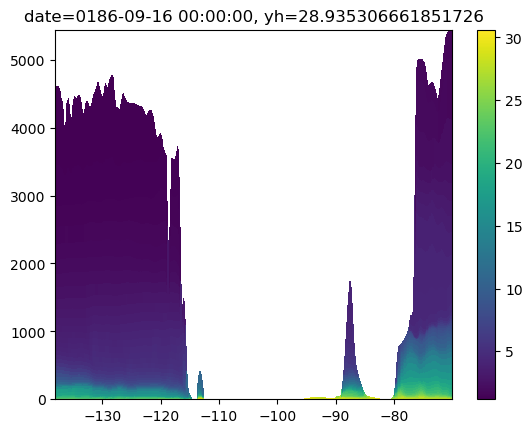

In [148]:
import matplotlib.pyplot as plt

plt.pcolor(
    z_section.xh*xr.ones_like(z_section.rho2_l),
    z_section,
    temp.transpose()
)
plt.colorbar()
plt.title(f'date={z_section.time.values}, yh={z_section.yh.values}')